# A/B testing or Multi-armed bandit? 
In this notebook, I will try to elucidate a long standing question of mine. Should I choose A/B testing or multi-armed bandit?
To do this, we will use python to simulate random client, and see for which case each algorithm performs the best!

## Assumptions

* There is a clear mesure of conversion or not/conversion.
* Each client is an independant random variable
* There is an underlying "true" conversion rate, which is static (this is probably the strongest assumption)



## Modelisation

Following the previous assumption, we can model each client as following a dual or n [bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution), for the number of page variant. 

### Algorithm definition

We define each algorithm as follows:

#### [A/B testing](https://en.wikipedia.org/wiki/A/B_testing)

* The user is randomly presented a variant of the page
* The action of the user is recorder to determine wether the page converts or not
* As soon as the result is statistically significant (p<5%), the users are only presented the most efficient variant

#### [Multi-armed bandit](https://en.wikipedia.org/wiki/A/B_testing)

Here we choose the UCB1 algorithm. This is an easy to implement algorithm with good performances. Plus I like the optimistic ideology of this algorithm. You can read an excellent article about it [there](https://jeremykun.com/2013/10/28/optimism-in-the-face-of-uncertainty-the-ucb1-algorithm/)

* First play all the option far an base estimate of the mean xi (for us x1 and x2)
* At each round n (n=1,2,3,...), in the past the option i having been played ni times, select the option that minimise xi+sqrt(2*log(n/ni)).
* Update xi and ni according to results

### Result definition

We want to know how each algorithm performs (ie which has the best global conversion):

* Regarding the delta of conversion between options (ie option 1 converts at 0.5+delta/2, and option 2 at 0.5-delta/2)
* Regarding the population (ie at the time the test stops)



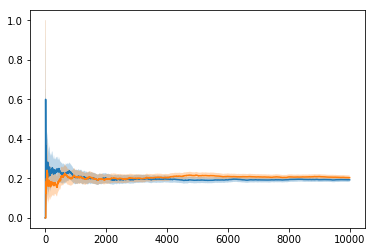

In [98]:
%matplotlib inline
from scipy.stats import bernoulli
import random
import scipy.stats
import matplotlib.pyplot as plt

def test_choice(choice, probability_array):
    return bernoulli.rvs(probability_array[choice],size=1)[0]

def A_B_test(probability_array,lenght):
    test_accumulator=[0] *len(probability_array)
    result_accumulator=[0] *len(probability_array)
    bound_accumulator=[[0,1]] *len(probability_array)
    mean_accumulator=[0] *len(probability_array)
    test_data=[]
    for i in range(0,lenght):
        topbounds=[i[1] for i in bound_accumulator]
        index_max = max(range(len(topbounds)), key=topbounds.__getitem__)
        low_value=bound_accumulator[index_max][0]
        del topbounds[index_max]
        if low_value>max(topbounds):
            choice=index_max
        else:
            choice=random.randint(0,len(probability_array)-1)
        test_accumulator[choice]+=1
        result=test_choice(choice,probability_array)
        result_accumulator[choice]+=result
        mean_accumulator[choice]=result_accumulator[choice]/test_accumulator[choice]
        if(result_accumulator[choice]>0):
            lo = scipy.stats.beta.ppf(0.025, result_accumulator[choice], test_accumulator[choice]-result_accumulator[choice])
            hi = scipy.stats.beta.ppf(0.975, result_accumulator[choice], test_accumulator[choice]-result_accumulator[choice])
            bound_accumulator[choice]=[lo,hi]
        test_data.append([mean_accumulator[:],bound_accumulator[:]])
    return test_data
    
lenght=10000
proba=[0.2,0.21]
retrun = A_B_test(proba,lenght)
for j in range(len(proba)):
    plt.plot([i[0][j] for i in retrun])
    plt.fill_between(range(0,lenght),[i[1][j][0] for i in retrun] , [i[1][j][1] for i in retrun], alpha=0.3)

plt.show()